Load the LLM

In [1]:
from langchain_community.llms.mlx_pipeline import MLXPipeline
from langchain_community.chat_models.mlx import ChatMLX
from langchain.callbacks.tracers import ConsoleCallbackHandler
from langchain.globals import set_verbose
from langchain.globals import set_debug

#set_debug(True)
set_verbose(True)

print('Loading model...')
# Load model from huggingface, using the MLX framework to take advantage of Apple Silicon
llm = MLXPipeline.from_model_id(
    #"mlx-community/Meta-Llama-3.1-8B-Instruct-8bit",
    #"mlx-community/Meta-Llama-3.1-8B-Instruct-bf16",
    "mlx-community/Qwen2.5-32B-Instruct-4bit", # Let's try using a larger model, see if that improves results
    #"mlx-community/Llama-3.2-3B-Instruct-8bit",
    pipeline_kwargs={"max_tokens": 2048, "temp": 0.2, "repetition_penalty":1.2},
)

# Setup verbose mode: https://stackoverflow.com/a/77629872/10914628
model = ChatMLX(llm=llm).with_config({'callbacks': [ConsoleCallbackHandler()]})
print('Model loaded.')


Loading model...


/Users/frieder/Documents/GitHub/procedural-stories/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Fetching 12 files: 100%|██████████| 12/12 [00:00<00:00, 260785.74it/s]


Model loaded.


Load the ontology

In [2]:
# from generator.utils.serializers import json2llmready

# print('Loading ontology...')
# with open("story.json", "r") as f:
#     ontology = json2llmready(f.read())
# print(ontology)

In [3]:
from urllib.parse import quote, unquote

def encode_entity_name(name: str) -> str:
    return quote(name)

def decode_entity_name(encoded_name: str) -> str:
    return unquote(encoded_name)

Define the setting of the story

In [4]:
setting = "Normandie viking du 9e siècle"

# 1. Generate the outline of the story world

In [5]:
OUTLINE_TEXT_PROMPT = """
You are the master writer tasked with creating a vibrant world specifically made to host a text adventure game for a player.
Write a few paragraphs describing the world of the story following the given narrative setting:

{{ setting }}

Your text should be quite short, concise and descriptive.
Your staff will use this text as the story world bible, they will write the characters, locations and specific events.
You should direct them as precisely as possible to create as coherent and unified world for the player to explore.
Define the player's role in this world, as well as a high level, open but concrete goal, conflict and motivations.
Write your output in {{ language }}.
"""

In [6]:
from langchain_core.prompts import PromptTemplate

language = "french"

prompt = PromptTemplate(
    input_variables=['setting', 'language'],
    template=OUTLINE_TEXT_PROMPT,
    template_format='jinja2'
)

chain = prompt | model

outline_text = chain.invoke({'setting': setting, 'language': language})

outline_text

Parent run ec4822a9-fe3d-4648-91e9-39841bcc9dbe not found for run 63ff098a-8ff3-44bc-ad63-d98c1a304e1d. Treating as a root run.


[llm/start] [llm:ChatMLX] Entering LLM run with input:
{
  "prompts": [
    "Human: \nYou are the master writer tasked with creating a vibrant world specifically made to host a text adventure game for a player.\nWrite a few paragraphs describing the world of the story following the given narrative setting:\n\nNormandie viking du 9e siècle\n\nYour text should be quite short, concise and descriptive.\nYour staff will use this text as the story world bible, they will write the characters, locations and specific events.\nYou should direct them as precisely as possible to create as coherent and unified world for the player to explore.\nDefine the player's role in this world, as well as a high level, open but concrete goal, conflict and motivations.\nWrite your output in french."
  ]
}
[llm/end] [llm:ChatMLX] [50.62s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "Dans le monde des Normands au IXème siècle, la société est dominée par les guerriers intrépides

AIMessage(content="Dans le monde des Normands au IXème siècle, la société est dominée par les guerriers intrépides et les navigateurs audacieux qui explorent de nouveaux horizons en longboat. Le joueur incarne un jeune Viking ambitieux cherchant à gagner gloire et richesse dans ce monde rude mais fascinant.\n\nLe nord de l'Europe est parsemé d'îles rocheuses, de fjords profonds et de vastes plaines où paissent des troupeaux. Les villages sont protégés par des palissades de bois tandis que les grands jarls résident dans des halls imposants aux murs décorés de trophées de bataille. \n\nLa quête principale consiste pour notre héros à rassembler une flotte suffisante afin de conquérir son propre territoire sur les terres lointaines. Pour cela, il devra prouver sa bravoure lors de raids contre les riches monastères ou villes côtières, négocier avec d'autres chefs Vikings pour s'allier à lui, et explorer des îles mystérieuses peuplées de créatures légendaires.\n\nLes conflits émergent entre 

In [7]:
print(outline_text.content)

Dans le monde des Normands au IXème siècle, la société est dominée par les guerriers intrépides et les navigateurs audacieux qui explorent de nouveaux horizons en longboat. Le joueur incarne un jeune Viking ambitieux cherchant à gagner gloire et richesse dans ce monde rude mais fascinant.

Le nord de l'Europe est parsemé d'îles rocheuses, de fjords profonds et de vastes plaines où paissent des troupeaux. Les villages sont protégés par des palissades de bois tandis que les grands jarls résident dans des halls imposants aux murs décorés de trophées de bataille. 

La quête principale consiste pour notre héros à rassembler une flotte suffisante afin de conquérir son propre territoire sur les terres lointaines. Pour cela, il devra prouver sa bravoure lors de raids contre les riches monastères ou villes côtières, négocier avec d'autres chefs Vikings pour s'allier à lui, et explorer des îles mystérieuses peuplées de créatures légendaires.

Les conflits émergent entre factions rivales se dispu

# 2. Generate locations

In [8]:
LOCATIONS_GENERATION_PROMPT = """
You are the master world writer for an interactive fiction.
On the basis of the given narrative context, create a list of locations in the world, which will be scenes in the IF.
Define at least 4 to 5 main locations, as well as intermediate locations if pertinent.
Your staff will use your work to refine each location, so you should make sure each location incoporates sufficient information for them to do so !
You must take utmost care in creating a logical topology with no islands and coherent connections.
Always refer to other locations using their "name" property in the links ! You should define all locations mentioned in the links.

Output your work in the following JSON format:
```json
    "Locations": [
        {
            "name": "Gravepine",
            "importance": "Either 'major' or 'minor', this annotation will influence how your staff will detail the"
            "description": "Description en quelques phrases du lieu, incorporant son atmosphère, son importance dans l'histoire et tout élément notable qui pourrait influencer les événements ou les personnages.",
            "links": ["Chateau"]
        },
        {
            "name": "Chateau",
            "importance": "Either 'major' or 'minor', this annotation will influence how your staff will detail the"
            "description": "Description en quelques phrases du lieu, incorporant son atmosphère, son importance dans l'histoire et tout élément notable qui pourrait influencer les événements ou les personnages.",
            "links": ["Gravepine", "Nom d'un autre lieu"]
        },
        ...
    ],
```

Narrative context:
{{ context }}

Your output JSON values should always be in {{ language }}
"""

In [10]:
from langchain_core.output_parsers import JsonOutputParser

prompt = PromptTemplate(
    input_variables=['setting'],
    template=LOCATIONS_GENERATION_PROMPT,
    template_format='jinja2'
)

parser = JsonOutputParser()

chain = prompt | model | parser

locations_output = chain.invoke({'context': outline_text.content, 'language': language})


Parent run 130df833-66f3-4c69-8e20-182bbffb3593 not found for run 72c519b7-3d3d-4ba3-8a73-68dc5cef9b0b. Treating as a root run.


[llm/start] [llm:ChatMLX] Entering LLM run with input:
{
  "prompts": [
    "Human: \nYou are the master world writer for an interactive fiction.\nOn the basis of the given narrative context, create a list of locations in the world, which will be scenes in the IF.\nDefine at least 4 to 5 main locations, as well as intermediate locations if pertinent.\nYour staff will use your work to refine each location, so you should make sure each location incoporates sufficient information for them to do so !\nYou must take utmost care in creating a logical topology with no islands and coherent connections.\nAlways refer to other locations using their \"name\" property in the links ! You should define all locations mentioned in the links.\n\nOutput your work in the following JSON format:\n```json\n    \"Locations\": [\n        {\n            \"name\": \"Gravepine\",\n            \"importance\": \"Either 'major' or 'minor', this annotation will influence how your staff will detail the\"\n           

In [11]:
location_outlines = locations_output['Locations']
location_outlines

[{'name': 'Village de Gravepine',
  'importance': 'major',
  'description': "Un village normand typique entouré d'une palissade de bois. C'est ici que commence l'aventure du protagoniste, un endroit simple mais solide où vivent des familles de pêcheurs et de fermiers. Il y a aussi plusieurs bâtiments importants comme la forge locale et le temple dédié aux dieux nordiques.",
  'links': ['Hall des Jarls', 'Port de Gravepine']},
 {'name': 'Hall des Jarls',
  'importance': 'major',
  'description': "L'impressionnant hall situé juste hors du Village de Gravepine, c'est là que réside le grand jarl local. Décoré de trophées de bataille et de runes magiques gravées dans les murs, cet espace sert également de place publique pour discuter affaires et partager repas après chaque raid réussi.",
  'links': ['Village de Gravepine', 'Forêt Sombre']},
 {'name': 'Port de Gravepine',
  'importance': 'major',
  'description': 'Point stratégique vital pour toute expédition maritime depuis Gravespine. Ici,

In [12]:
from dataclasses import abc, dataclass, field
from typing import Optional, List

@dataclass
class LocationData:
    name: str
    description: str
    stance: Optional[str] = None
    relationships: Optional[List[str]] = field(default_factory=list)
    characters: Optional[List[str]] = field(default_factory=list)
    items: Optional[List[dict]] = field(default_factory=list)
    
    def to_llm_string(self) -> str:
        string = f'"{self.name}": {self.description}\n\t'
        if self.relationships:
            string += f'"{self.name}" est connecté à {' et '.join(f'"{rel}"'for rel in self.relationships)}\n\t'
        if self.stance:
            string += f'"{self.name}" est {self.stance} envers le joueur'

        return string
    
print(LocationData(name='Gravepine', description='blabla', relationships=['chateau', 'foret']).to_llm_string())

"Gravepine": blabla
	"Gravepine" est connecté à "chateau" et "foret"
	


In [13]:
# Encoder les lieux sous forme d'objets
locations = []
for loc in location_outlines:
    location = LocationData(name=loc['name'], description=loc['description'], relationships=loc['links'])
    print(location)
    locations.append(location)

LocationData(name='Village de Gravepine', description="Un village normand typique entouré d'une palissade de bois. C'est ici que commence l'aventure du protagoniste, un endroit simple mais solide où vivent des familles de pêcheurs et de fermiers. Il y a aussi plusieurs bâtiments importants comme la forge locale et le temple dédié aux dieux nordiques.", stance=None, relationships=['Hall des Jarls', 'Port de Gravepine'], characters=[], items=[])
LocationData(name='Hall des Jarls', description="L'impressionnant hall situé juste hors du Village de Gravepine, c'est là que réside le grand jarl local. Décoré de trophées de bataille et de runes magiques gravées dans les murs, cet espace sert également de place publique pour discuter affaires et partager repas après chaque raid réussi.", stance=None, relationships=['Village de Gravepine', 'Forêt Sombre'], characters=[], items=[])
LocationData(name='Port de Gravepine', description='Point stratégique vital pour toute expédition maritime depuis Gr

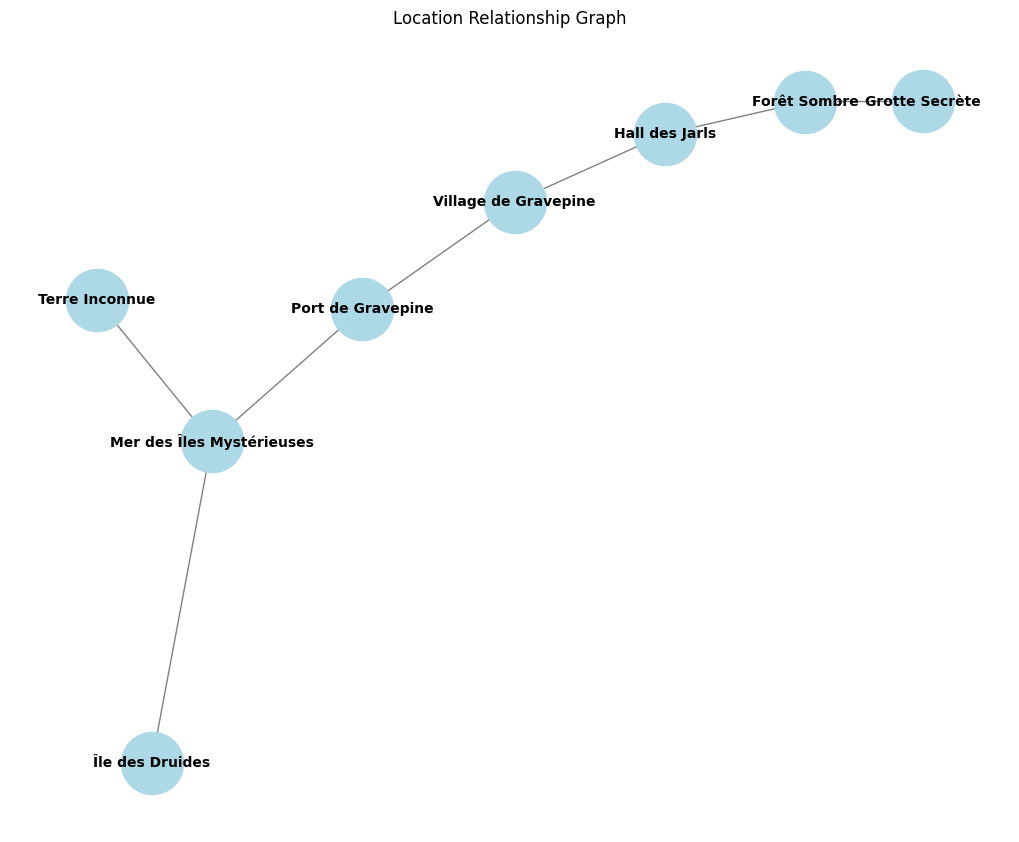

In [14]:
import networkx as nx
import matplotlib.pyplot as plt

def display_location_relationships(locations: List[LocationData]):
    # Create a graph
    G = nx.Graph()

    # Add nodes and edges
    for location in locations:
        G.add_node(location.name)  # Add each location as a node
        for related_location in location.relationships:
            # Create edges for relationships
            G.add_edge(location.name, related_location)

    # Draw the graph
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G)  # Positioning of the graph

    # Draw nodes, edges, and labels
    nx.draw(G, pos,
            with_labels=True,
            node_color='lightblue',
            node_size=2000,
            font_size=10,
            font_weight='bold',
            edge_color='gray')
    plt.title('Location Relationship Graph')
    plt.show()

display_location_relationships(locations)

Structure works, it's a hub structure with linear branches. Good enough !
Extra points for the water structure

In [15]:
STORY_OUTLINE_PROMPT = """
# Instructions pour la génération
Vous êtes le scénariste de l'histoire pour une aventure textuelle générative.
Sur la base du contexte narratif et des lieux qui composent le monde ci-dessous, générez les grandes lignes d'une histoire possible en tenant créant les éléments suivants :

    Joueur : Établir la position et le rôle du joueur dans l'histoire, en précisant leur identité, leurs motivations et leur lien avec les personnages principaux. Décrire le point de départ du joueur et son rôle dans le récit global.
    Personnages: Etablir une liste d'au moins **3 à 5** personnages principaux de l'histoire, sans rentrer dans trop de détails mais en évoquant leur fonction narrative et leurs relations (entre eux et avec le joueur). Veille à établir au moins un antagoniste principal.
    Objectif : Définir l'objectif global du joueur, en précisant le problème principal à résoudre ou l'enjeu narratif qui motive l'action.
    Événements : Décrire au moins 1 à 3 événements clés qui alimentent l'histoire et doivent être déclenchés par l'action du joueur.
    Objets : Générer uniquement les éléments essentiels nécessaires pour compléter l'histoire (objets de quête) si c'est mentionné dans le contexte narratif, en incluant : Un nom et une description de chaque objet, avec sa fonction dans le récit. Indiquer le lieu où se trouve chaque objet, en s'assurant qu'il s'intègre logiquement dans le monde.
    Commentaires : Inclure tout commentaire supplémentaire qui pourrait guider la génération de détails supplémentaires ou éclaircir des éléments importants de l'histoire.

# Format de sortie
D'abord, raisonner sur le contexte narratif donné et son importance pour la cohérence du monde et de l'histoire, l'intrigue principale (qui doit être de nature ouverte), et les relations des personnages.
Fournir les éléments dans un fichier json structuré selon le format suivant:
{
    "Player": {
        "name": "Donner le nom du personnage qu'incarne le joueur",
        "description": "Description en quelques phrases du personnage qu'incarne le joueur",
        "location": "Nom du lieu de départ de l'histoire"
    },
    "Characters": [
        {
            "name": "Nom propre du personnage 1",
            "description": "description en une phrase du personnage, incorporant son rôle et sa fonction dans l'histoire, et sa relation aux autres personnages.",
            "location": "Nom du lieu ou se trouve le personnage"
        },
        ...
    ],
    "Goal": {
        "description": "description du problème ou de l'enjeu qui motive le joueur. La résolution du jeu doit rester ouverte"
        "requiresItem": "(FACULTATIF) S'il un objet qui est le centre de l'histoire et doit être récupéré pour gagner, l'indiquer ici. Sinon, omettre ce champs."
    },
    "Events": [
        {
            "name": "Evènement 1",
            "description": "description de l'évènement",
            "condition": "description de la condition qui déclenche l'évènement (devrait être déclenché par l'action du joueur !)",
            "consequences": ["Une ou plusieurs conséquences à l'évènement", "deuxième conséquence possible"]
        },
        ...
    ],
    "Items": [
        {
            "name": "Nom de l'objet",
            "description": "description courte de l'objet et de sa fonction dans le récit",
            "location": "(OBLIGATOIRE) Nom du lieu qui contient l'objet"
        },
        ...
    ],
    "Comments": [
        "Tout commentaire que tu voudrais ajouter pour guider la génération de détails supplémentaires et pendant le jeu. Sois précis plus que général: donne des commentaires qui peuvent être exploités. Des éléments importants de l'histoire"
    ]
}


# Lieux du monde
{%- for location in locations %}
{{ location.to_llm_string() }}
{%- endfor %}

# Contexte narratif
{{ setting }}

Rappel: Ne répète pas les lieux du monde. Ton objectif est de développer une histoire qui fonctionne dans ce monde. N'ajoute que des éléments nouveaux dans le JSON. Fournis seulement les informations sur le joueur, son objectif, les personnages principaux, les évènements principaux, les éventuels objets principaux.

# Résultat
"""

In [16]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import JsonOutputParser

prompt = PromptTemplate(
    template=STORY_OUTLINE_PROMPT,
    template_format='jinja2'
)

parser = JsonOutputParser() # OutlineParser

chain = prompt | model | parser

story_outline = chain.invoke({'setting': outline_text.content, 'locations': locations})



Parent run 37d5a622-45d9-4c7e-a44c-e6a897cb97f9 not found for run 4935378e-3106-40b2-8296-a3cbe491c8c2. Treating as a root run.


[llm/start] [llm:ChatMLX] Entering LLM run with input:
{
  "prompts": [
    "Human: \n# Instructions pour la génération\nVous êtes le scénariste de l'histoire pour une aventure textuelle générative.\nSur la base du contexte narratif et des lieux qui composent le monde ci-dessous, générez les grandes lignes d'une histoire possible en tenant créant les éléments suivants :\n\n    Joueur : Établir la position et le rôle du joueur dans l'histoire, en précisant leur identité, leurs motivations et leur lien avec les personnages principaux. Décrire le point de départ du joueur et son rôle dans le récit global.\n    Personnages: Etablir une liste d'au moins **3 à 5** personnages principaux de l'histoire, sans rentrer dans trop de détails mais en évoquant leur fonction narrative et leurs relations (entre eux et avec le joueur). Veille à établir au moins un antagoniste principal.\n    Objectif : Définir l'objectif global du joueur, en précisant le problème principal à résoudre ou l'enjeu narratif

In [17]:
story_outline

{'Player': {'name': 'Erik Stormbringer',
  'description': 'Un jeune Viking ambitieux originaire du Village de Gravepine, désireux de faire preuve de bravoure et de gagner la reconnaissance nécessaire pour diriger sa propre flotte et conquérir un nouveau territoire.',
  'location': 'Village de Gravepine'},
 'Characters': [{'name': 'Jarl Bjorn Ironheart',
   'description': 'Jarlor de Gravepine respecté pour sa force physique et son leadership. Erik cherche à gagner son appui pour organiser une expédition vers Terre Inconnue.',
   'location': 'Hall des Jarls'},
  {'name': 'Sigrid the Seafarer',
   'description': 'Experte navigatrice et femme libre qui propose ses services à Erik pour aider dans la navigation vers les terres inexplorées. Son aide sera cruciale pour traverser Mer des Îles Mystérieuses.',
   'location': 'Port de Gravepine'},
  {'name': 'Druid Alvar',
   'description': 'Ancien druide vivant seul sur Île des Druides, détenteur de pouvoirs magiques capables de changer le cours 

In [18]:
@dataclass
class CharacterData:
    name: str
    description: str
    location: str
    relationships: Optional[list] = field(default_factory=list)
    importance: Optional[str] = 'minor'


In [19]:
# Convert JSON to CharacterData objects
characters = list()

for character in story_outline['Characters']:
    character_obj = CharacterData(
        name = character.get('name'),
        description = character.get('description'),
        location = character.get('location'),
        importance = 'major'
    )
    
    characters.append(character_obj)
    print(character_obj)

CharacterData(name='Jarl Bjorn Ironheart', description='Jarlor de Gravepine respecté pour sa force physique et son leadership. Erik cherche à gagner son appui pour organiser une expédition vers Terre Inconnue.', location='Hall des Jarls', relationships=[], importance='major')
CharacterData(name='Sigrid the Seafarer', description='Experte navigatrice et femme libre qui propose ses services à Erik pour aider dans la navigation vers les terres inexplorées. Son aide sera cruciale pour traverser Mer des Îles Mystérieuses.', location='Port de Gravepine', relationships=[], importance='major')
CharacterData(name='Druid Alvar', description='Ancien druide vivant seul sur Île des Druides, détenteur de pouvoirs magiques capables de changer le cours des combats. Sa coopération permettrait à Erik d’avoir un avantage décisif.', location='Île des Druides', relationships=[], importance='major')


In [20]:
@dataclass
class PlayerData:
    name: str
    description: str
    goal: str
    location: str

In [21]:
player = PlayerData(
    name = story_outline['Player']['name'],
    description = story_outline['Player']['description'],
    goal = story_outline['Goal']['description'],
    location = story_outline['Player']['location'],
)
player

PlayerData(name='Erik Stormbringer', description='Un jeune Viking ambitieux originaire du Village de Gravepine, désireux de faire preuve de bravoure et de gagner la reconnaissance nécessaire pour diriger sa propre flotte et conquérir un nouveau territoire.', goal='Assemblage d’une flotte capable de soutenir une campagne militaire visant à conquérir Terre Inconnue. Erik doit accomplir des missions pour accumuler prestige et ressources avant de pouvoir convaincre Jarl Björn Ironheart de financer son voyage.', location='Village de Gravepine')

In [22]:
CHARACTER_EXPANSION_PROMPT = """
Using the following details, generate a JSON output with additional information about the character.

Character Name: {{character.name}}
Description: {{character.description}}
Starting location: {{character.location}}

Other main characters of the story:
{%- for char in other_characters %}
    "{{ char.name }}": {{ char.description }} (is located at {{char.location}})
{%- endfor %}

The player:
    "{{ player.name }}": {{ player.description }} (is located at {{player.location}})
    The player has the goal: {{player.goal}}

Please include:
- A significant backstory element that explain their current situation. Improving the character's current description
- One or two relationships that the character has with other main characters or the player.

Ensure that all generated elements align with the narrative and character dynamics already established in the outline.
Output your response in the following JSON format:

{
    "description": "The updated, expanded description of the character, defining their goals, motivations, and conflicts",
    "relationships": [
        {
            "type": "either 'friend', 'lover', 'enemy', 'rival', 'subject', 'ruler', no matter the language ",
            "target": "Name of the character which has that relationship with {{character.name}}"
        },
        ...
    ]
}

Write all the JSON value strings in {{language}}, except relationship types.
"""

In [23]:

prompt = PromptTemplate(
    template=CHARACTER_EXPANSION_PROMPT,
    template_format='jinja2'
)

parser = JsonOutputParser()

chain = prompt | model | parser

expanded_main_characters = list()

# Expand each character's description and relationships
for character in characters:

    # Get the list of other main characters
    other_characters = list()
    for other_character in characters:
        if other_character.name == character.name:
            continue
        other_characters.append(other_character)
    
    print(character)

    res = chain.invoke({"setting": outline_text.content,
                        "character": character,
                        "player": player,
                        "other_characters": other_characters,
                        "language": language})

    character.description = res['description']
    character.relationships = res['relationships']
    expanded_main_characters.append(character)
    print('----*----')
    print(res)
    print('----*----')

Parent run a63af25e-0214-4f8b-b16e-b2cc2e0b6d3f not found for run 6eecedc5-4f4d-46ce-8654-6ea0a700bd25. Treating as a root run.


CharacterData(name='Jarl Bjorn Ironheart', description='Jarlor de Gravepine respecté pour sa force physique et son leadership. Erik cherche à gagner son appui pour organiser une expédition vers Terre Inconnue.', location='Hall des Jarls', relationships=[], importance='major')
[llm/start] [llm:ChatMLX] Entering LLM run with input:
{
  "prompts": [
    "Human: \nUsing the following details, generate a JSON output with additional information about the character.\n\nCharacter Name: Jarl Bjorn Ironheart\nDescription: Jarlor de Gravepine respecté pour sa force physique et son leadership. Erik cherche à gagner son appui pour organiser une expédition vers Terre Inconnue.\nStarting location: Hall des Jarls\n\nOther main characters of the story:\n    \"Sigrid the Seafarer\": Experte navigatrice et femme libre qui propose ses services à Erik pour aider dans la navigation vers les terres inexplorées. Son aide sera cruciale pour traverser Mer des Îles Mystérieuses. (is located at Port de Gravepine)

Parent run 2f45b533-b836-4fa8-978f-8dd9166e93e2 not found for run bcf8b8cc-5117-4768-b6b1-8d47a98aeca6. Treating as a root run.


[llm/end] [llm:ChatMLX] [90.71s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "{\n  \"character_name\": \"Jarl Bjorn Ironheart\",\n  \"description\": \"Respecté parmi tous les jarls, Jarl Bjorn Ironheart est non seulement connu pour sa force prodigieuse mais aussi pour avoir mené plusieurs raids victorieux contre leurs ennemis traditionnels. Né sous l'ombre de grands héros vikings, il porte en lui-même cette volonté indomptée de défendre et d'étendre leur terre natale. Cependant, malgré toute sa gloire passée, il reste prudent face aux nouvelles aventures que certains jeunes guerriers comme Erik souhaitent entreprendre.\",\n  \"starting_location\": \"Hall des Jarls\",\n  \"goals_and_motivations\": \"Son objectif principal est maintenant de maintenir la paix et la prospérité au sein de son peuple sans compromettre les traditions ancestrales. Il hésite quant à donner son approbation ou même son assistance financière à ceux qui cherchent à explorer des t

Parent run c1261791-abce-4c2b-91fe-6e47f0510384 not found for run d7b03446-78ae-49d7-8aa0-3a4adf0566bf. Treating as a root run.


[llm/end] [llm:ChatMLX] [51.72s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "{\n  \"character_name\": \"Sigrid the Seafarer\",\n  \"description\": \"Experte navigatrice et femme libre, Sigrid the Seafarer possède une connaissance approfondie des mers et des vents. Elle offre ses talents précieux à Erik pour explorer les terres inconnues au-delà de la Mer des Îles Mystérieuses. Ayant perdu sa famille lors d'une terrible tempête maritime, elle voit maintenant chaque expédition comme une chance de trouver quelque chose plus grand qu'elle-même - peut-être même une nouvelle maison. Son aide s'avère essentielle car sans elle, Erik serait incapable de naviguer avec succès.\",\n  \"starting_location\": \"Port de Gravepine\",\n  \"goals_and_motivations\": [\"Aider Erik dans sa quête\", \"Trouver un sentiment de paix après avoir enduré beaucoup\"],\n  \"conflicts\": [\"La peur persistante des tempêtes marines\", \"Le désir de prouver sa valeur à ceux qui dout

In [24]:
characters

[CharacterData(name='Jarl Bjorn Ironheart', description="Respecté parmi tous les jarls, Jarl Bjorn Ironheart est non seulement connu pour sa force prodigieuse mais aussi pour avoir mené plusieurs raids victorieux contre leurs ennemis traditionnels. Né sous l'ombre de grands héros vikings, il porte en lui-même cette volonté indomptée de défendre et d'étendre leur terre natale. Cependant, malgré toute sa gloire passée, il reste prudent face aux nouvelles aventures que certains jeunes guerriers comme Erik souhaitent entreprendre.", location='Hall des Jarls', relationships=[{'type': 'ruler', 'target': 'Villageois de Gravepine'}, {'type': 'subject', 'target': 'Erik Stormbringer'}], importance='major'),
 CharacterData(name='Sigrid the Seafarer', description="Experte navigatrice et femme libre, Sigrid the Seafarer possède une connaissance approfondie des mers et des vents. Elle offre ses talents précieux à Erik pour explorer les terres inconnues au-delà de la Mer des Îles Mystérieuses. Ayant 

In [25]:
@dataclass
class ItemData:
    name: str
    description: str
    location: str
    quantity: Optional[int] = 1
    importance: Optional[str] = 'minor'

In [26]:
items = list()
for item in story_outline.get('Items'):
    item_obj = ItemData(
        name = item.get('name'),
        description = item.get('description'),
        location = item.get('location'),
        quantity = int(item.get('quantity', 1)),
        importance = 'major'
    )
    items.append(item_obj)
items

[ItemData(name='Amulette Runique', description="Objet sacré trouvé dans Grotte Secrète, doté de propriétés protectrices qui augmenteraient considérablement chances survies d'Erik.", location='Grotte Secrète', quantity=1, importance='major')]

In [27]:
all_item_names = list()
for item in items:
    all_item_names.append(item.name)

all_character_names = list()

all_character_names.append(player.name)

for character in characters:
    all_character_names.append(character.name)
    

print(all_item_names)
print(all_character_names)

['Amulette Runique']
['Erik Stormbringer', 'Jarl Bjorn Ironheart', 'Sigrid the Seafarer', 'Druid Alvar']


In [28]:
LOCATION_EXPANSION_PROMPT = """
Using the following details, generate a JSON output with additional information about the location.

Setting of the story: {{setting}}

Location Name: {{location.name}}
Description: {{location.description}}
Neighboring locations:
{%- for nearby_location in nearby_locations %}
    {{ nearby_location.to_llm_string() }}
{%- endfor %}

{%- if characters %}
Main characters in "{{location.name}}":
{%- if player %}
    - "{{player.name}}" (Player): {{player.description}}
        The player has the goal: {{player.goal}}
{%- endif %}
{%- for character in characters %}
    - "{{ character.name }}": {{ character.description }}
{%- endfor %}
{%- endif %}

{%- if items %}
The location contains the quest item(s):
{%- for item in items %}
    - "{{ item.name }}": {{ item.description }}
{%- endfor %}
{%- endif %}

please DO NOT include this information in your output

Please include:
- Up to two secondary characters that would be relevant to this location. Keep in mind that secondary caracters should have a use to the player, that is either to give the player some important information (define specifically the information), some items, trade or offer a challenge, or other if it is relevant to the scene and the story. You can and should use less, or even no characters, depending on the location ! Only add characters where pertinent.
- Up to two items that could be found or are important in this location. Items should always have a clear use at least in the scene.

Do not call any character these names: {{banned_character_names}}
Do not call any item these names: {{banned_item_names}}
{%- if used_roles %}
Already used secondary character roles (Try not to repeat them too much. Only if it really makes sense): {{used_roles}}
{%- endif %}

Ensure that all generated elements align with the narrative and character dynamics already established in the outline.

Make sure to output the list of characters as JSON, following this exact model:

{
    "Description": "A longer, more detailed description of the location and perhaps its different parts and their function in the story"
    "Characters": [
        {
            "name": "The name of the character",
            "description": "A concise description of the character and their function in the scene.",
            "role": "One or two words describing this character's function"
        },
        ...
    ],
    "Items": [
        {
            "name": "The name of the item",
            "description": "A concise description of the item and its function.",
            "quantity": 1,
        },
        ...
    ]
}

Generate all output in {{ language }}
"""

In [29]:

prompt = PromptTemplate(
    template=LOCATION_EXPANSION_PROMPT,
    template_format='jinja2'
)

parser = JsonOutputParser()

chain = prompt | model | parser


used_roles = list()
banned_character_names = all_character_names
banned_item_names = all_item_names

expanded_locations = list()
for location in locations:
    # Characters
    characters_in_location = list()
    for character in characters:
        if character.location == location.name:
            characters_in_location.append(character)
    
    # Player
    player_in_location = None
    if player.location == location.name:
        player_in_location = player
    
    # Items
    items_in_location = list()
    for item in items:
        if item.location == location.name:
            items_in_location.append(item)
    
    nearby_location = list()
    for other_location in locations:
        if other_location.name in location.relationships:
            nearby_location.append(other_location)

    res = chain.invoke({"setting": outline_text.content,
                        "location": location,
                        "nearby_locations": nearby_location,
                        "characters": characters_in_location,
                        "items": items_in_location,
                        "player": player_in_location,
                        "banned_item_names": all_item_names,
                        "banned_character_names": all_character_names,
                        "used_roles": used_roles,
                        "language": language})
    
    for item in res['Items']:
        all_item_names.append(item.get('name'))
    
    for character in res.get('Characters'):
        all_character_names.append(character.get('name'))
        used_roles.append(character.get('role'))

    expanded_locations.append(res)
    print('----*----')
    print(res)
    print('----*----')


Parent run 45b3ff5e-da02-43da-87e3-b673b79e79e8 not found for run 2f5b55b8-cfc6-4803-9ecb-0c85b80498be. Treating as a root run.


[llm/start] [llm:ChatMLX] Entering LLM run with input:
{
  "prompts": [
    "Human: \nUsing the following details, generate a JSON output with additional information about the location.\n\nSetting of the story: Dans le monde des Normands au IXème siècle, la société est dominée par les guerriers intrépides et les navigateurs audacieux qui explorent de nouveaux horizons en longboat. Le joueur incarne un jeune Viking ambitieux cherchant à gagner gloire et richesse dans ce monde rude mais fascinant.\n\nLe nord de l'Europe est parsemé d'îles rocheuses, de fjords profonds et de vastes plaines où paissent des troupeaux. Les villages sont protégés par des palissades de bois tandis que les grands jarls résident dans des halls imposants aux murs décorés de trophées de bataille. \n\nLa quête principale consiste pour notre héros à rassembler une flotte suffisante afin de conquérir son propre territoire sur les terres lointaines. Pour cela, il devra prouver sa bravoure lors de raids contre les rich

Parent run 6945fc56-302b-487b-9b71-dc2557b587fa not found for run 161dba65-ab2a-48b9-85cd-0c419391ac96. Treating as a root run.


[llm/end] [llm:ChatMLX] [77.01s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "```json\n{\n    \"Description\": \"Un village normand typique entouré d'une palissade de bois. C'est ici que commence l'aventure du protagoniste, un endroit simple mais solide où vivent des familles de pêcheurs et de fermiers. Il y a aussi plusieurs bâtiments importants comme la forge locale et le temple dédié aux dieux nordiques. Ce lieu jouxte deux autres lieux clés : le Hall des Jarls et le Port de Gravepine.\",\n    \"Characters\": [\n        {\n            \"name\": \"Thora la Forgeronne\",\n            \"description\": \"Une femme robuste chargée de fabriquer armes et outils pour les habitants du village. Elle possède des compétences précieuses pour améliorer les équipements du joueur avant une mission importante.\",\n            \"role\": \"Fournisseur\"\n        },\n        {\n            \"name\": \"Ormr le Sage\",\n            \"description\": \"Ancien druide resp

Parent run 77020510-65d2-4122-9752-378f6c3af25b not found for run 2123067e-32ed-4a15-ba87-e3a2ca71df06. Treating as a root run.


[llm/end] [llm:ChatMLX] [58.20s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "```json\n{\n    \"Description\": \"L'impressionnant hall situé juste hors du Village de Gravepine, c'est là que réside le grand jarl local. Décoré de trophées de bataque et de runes magiques gravées dans les murs, cet espace sert également de place publique pour discuter affaires et partager repas après chaque raid réussi.\",\n    \"Characters\": [\n        {\n            \"name\": \"Skadi la Voyante\",\n            \"description\": \"Une femme âgée respectée pour ses prédictions précises. Skadi peut donner des informations cruciales sur les futures missions et dangers potentiels.\",\n            \"role\": \"Oracle\"\n        }\n    ],\n    \"Items\": [\n        {\n            \"name\": \"Bouclier Ornamenté\",\n            \"description\": \"Un bouclier ancien orné de symboles runiques protecteurs. Utile pour augmenter la protection pendant les combats.\",\n            \"qu

Parent run a6b2450b-1312-4de0-92cb-bf36295723dd not found for run be86fd2e-5bd2-41ed-b267-64a42a17fe6e. Treating as a root run.


[llm/end] [llm:ChatMLX] [82.20s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "```json\n{\n    \"Description\": \"Point stratégique vital pour toute expédition maritime depuis Gravespine. Ici, on peut voir des navires longboats prêt à partir vers leur prochaine destination : pillage, exploration ou commerce. Des marchands locaux vendent leurs produits près du port. Ce lieu joue un rôle crucial dans les préparations des expeditions maritimes et est souvent fréquenté par des aventuriers et commerçants.\",\n    \"Characters\": [\n        {\n            \"name\": \"Gunnar le Marchand\",\n            \"description\": \"Un homme robuste et bien informé, Gunnar propose divers équipements nécessaires aux voyages marins. Il fournit également des informations cruciales sur les routes commerciales sûres et les points d'intérêt le long des côtes voisines.\",\n            \"role\": \"Marchand\"\n        },\n        {\n            \"name\": \"Hilda la Cartographe\"

Parent run a3eb44bd-3d94-4698-a4c1-5efbcf2bf168 not found for run 1c6e21e1-93d5-4095-89ca-a6698e11cc23. Treating as a root run.


[llm/end] [llm:ChatMLX] [67.03s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "```json\n{\n    \"Description\": \"Une immense étendue forestière sombre et dense bordant le Hall des Jarls. Elle abrite divers animaux fauves et certains disent même avoir vu des trolls errant dans cette région. La forêt offre des opportunités pour la chasse et la collecte de ressources essentielles. En son sein, se cache aussi une Grotte Secrète remplie de trésors anciens, peut-être gardée par des créatures légendaires.\",\n    \"Characters\": [\n        {\n            \"name\": \"Ogmund le Chasseur\",\n            \"description\": \"Un homme robuste et expérimenté dans l’art de la traque et de la survie en forêt. Il fournit des informations précises sur les dangers potentiels et les points stratégiques de la Forêt Sombre.\",\n            \"role\": \"Informateur\"\n        }\n    ],\n    \"Items\": [\n        {\n            \"name\": \"Herbe Magique\",\n            \"desc

Parent run 8742d859-f9b8-45f2-a47c-345d5aacd2e0 not found for run f9c27c8d-cb6c-4080-a041-dd503d76d74b. Treating as a root run.


[llm/end] [llm:ChatMLX] [60.46s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "```json\n{\n    \"Description\": \"Cachée quelque part dans Forêt Sombre, cette grotte contient des trésors perdus datant de temps immémoriaux. Certaines légendes racontent qu'elle serait gardée par des créatures mythologiques telles que des géants ou des dragons. La forêt environnante est sombre et dense, bordant également le Hall des Jarls. On y trouve des animaux fauves et peut-être des trolls. Cette zone est souvent utilisée pour chasser ou trouver des ressources naturelles essentielles.\",\n    \"Characters\": [\n        {\n            \"name\": \"Grimgor le Rôdeur\",\n            \"description\": \"Un ancien membre du clan local connu pour être un excellent explorateur. Il pourrait donner des informations précieuses sur comment entrer dans la grotte sans attirer l’attention des créatures qui la gardent.\",\n            \"role\": \"Explorateur\"\n        }\n    ],\n   

Parent run 410995c2-6714-40e9-8c85-4477ed1bf531 not found for run c417f399-a6a4-4215-bbad-376494f54231. Treating as a root run.


[llm/end] [llm:ChatMLX] [62.54s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "```json\n{\n    \"Description\": \"Cette mer recouvre nombre d’îles non cartographiées pleines de dangers potentiels tels que des tempêtes imprévues ou des pirates. Elle offre également des opportunités pour découvrir de nouvelles terres et améliorer sa fortune grâce au pillage ou au commerce. La Mer des Îles Mystérieuses relie plusieurs lieux importants comme Port de Gravepine et Terre Inconnue, faisant d'elle un passage crucial pour les explorateurs et les aventuriers.\",\n    \"Characters\": [\n        {\n            \"name\": \"Olav le Navigateur\",\n            \"description\": \"Un ancien capitaine expérimenté qui partage volontiers ses connaissances sur les courants océaniques et les risques liés aux passages dangereux. Il peut fournir des conseils cruciaux pour éviter les pires pièges naturels de cette région.\",\n            \"role\": \"Conseiller\"\n        }\n   

Parent run 4f1482de-5117-4cd6-9db0-cab37870915d not found for run 3405212e-3398-40a4-bb6a-7d11d6dedb15. Treating as a root run.


[llm/end] [llm:ChatMLX] [64.56s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "```json\n{\n    \"Description\": \"Petite île située loin des routes commerciales connues, habitée uniquement par des druides qui pratiquent des rituels secrets. Ces derniers possèdent des connaissances précieuses sur la médecine herboriste et peuvent offrir des sorts bénéfiques si vous réussissez à obtenir leur confiance. L'île abrite également plusieurs sanctuaires naturels et anciennes pierres dressées qui ont des significations spirituelles importantes.\",\n    \"Characters\": [\n        {\n            \"name\": \"Sylvain le Guetteur\",\n            \"description\": \"Un ancien membre du clan druide qui veille maintenant seul près des falaises. Sylvain peut fournir des informations cruciales sur les mouvements des navires ennemis et les conditions maritimes aléatoires de la Mer des Îles Mystérieuses.\",\n            \"role\": \"Guetteur\"\n        }\n    ],\n    \"Items

In [30]:
expanded_locations[0]

{'Description': "Un village normand typique entouré d'une palissade de bois. C'est ici que commence l'aventure du protagoniste, un endroit simple mais solide où vivent des familles de pêcheurs et de fermiers. Il y a aussi plusieurs bâtiments importants comme la forge locale et le temple dédié aux dieux nordiques. Ce lieu jouxte deux autres lieux clés : le Hall des Jarls et le Port de Gravepine.",
 'Characters': [{'name': 'Thora la Forgeronne',
   'description': 'Une femme robuste chargée de fabriquer armes et outils pour les habitants du village. Elle possède des compétences précieuses pour améliorer les équipements du joueur avant une mission importante.',
   'role': 'Fournisseur'},
  {'name': 'Ormr le Sage',
   'description': 'Ancien druide respecté qui partage des connaissances anciennes et donne des conseils utiles concernant les routes maritimes et les dangers potentiels rencontrés durant les voyages.',
   'role': 'Conseiller'}],
 'Items': [{'name': 'Carte des Fjords',
   'descrip

In [31]:
# for character in characters:
#     character.importance = 'major'

for location, expanded_location in zip(locations, expanded_locations):
    
    # Here we replace, but we could have a long_description and a short_description
    location.description = expanded_location.get('Description')
    
    for character in expanded_location.get('Characters'):
        character_obj = CharacterData(
            name = character.get('name'),
            description = character.get('description'),
            location = location.name,
            importance = 'minor'
        )
        
        characters.append(character_obj)
    
    for item in expanded_location.get('Items'):
        item_obj = ItemData(
            name = item.get('name'),
            description = item.get('description'),
            location = location.name,
            quantity = int(item.get('quantity', 1))
        )
        
        items.append(item_obj)
    

    

In [32]:
print(locations)
print(characters)
print(items)

[LocationData(name='Village de Gravepine', description="Un village normand typique entouré d'une palissade de bois. C'est ici que commence l'aventure du protagoniste, un endroit simple mais solide où vivent des familles de pêcheurs et de fermiers. Il y a aussi plusieurs bâtiments importants comme la forge locale et le temple dédié aux dieux nordiques. Ce lieu jouxte deux autres lieux clés : le Hall des Jarls et le Port de Gravepine.", stance=None, relationships=['Hall des Jarls', 'Port de Gravepine'], characters=[], items=[]), LocationData(name='Hall des Jarls', description="L'impressionnant hall situé juste hors du Village de Gravepine, c'est là que réside le grand jarl local. Décoré de trophées de bataque et de runes magiques gravées dans les murs, cet espace sert également de place publique pour discuter affaires et partager repas après chaque raid réussi.", stance=None, relationships=['Village de Gravepine', 'Forêt Sombre'], characters=[], items=[]), LocationData(name='Port de Grav

In [33]:
print(player)

PlayerData(name='Erik Stormbringer', description='Un jeune Viking ambitieux originaire du Village de Gravepine, désireux de faire preuve de bravoure et de gagner la reconnaissance nécessaire pour diriger sa propre flotte et conquérir un nouveau territoire.', goal='Assemblage d’une flotte capable de soutenir une campagne militaire visant à conquérir Terre Inconnue. Erik doit accomplir des missions pour accumuler prestige et ressources avant de pouvoir convaincre Jarl Björn Ironheart de financer son voyage.', location='Village de Gravepine')


# Convert informations to knowledge graph

In this step, we convert the JSON-like structured data into entities in an ontology describing the logic of a story world, creating a model for the story we want to generate later.

In [44]:
from owlready2 import *

from ontology_manager import list_onto, add_location

# Create an ontology
onto = get_ontology("http://www.florianrieder.com/story.owl")

with onto:
    # Class Definitions
    class Entity(Thing):
        label = "Entité"

    class Character(Entity):
        """Represents a character in the story, such as a player or NPC."""
        label = "Personnage"

    class Player(Character):
        label = "Joueur"

    class Location(Thing):
        label = "Lieu"

    class Item(Entity):
        label = "Objet"

    class Action(Thing):
        """Represents an action that can be performed by a character."""
        label = "Action"
        comment = "Une action que peut prendre un personnage"

    class Event(Thing):
        label = "Evènement"

    class Consequence(Thing):
        label = "Conséquence"

    class Emotion(Thing):
        label = "Emotion"

    class Goal(Thing):
        label = "Objectif"

    class PersonalityTrait(Thing):
        label = "Trait de personnalité"

    class Role(Thing):
        label = "Role"

    class Condition(Thing):
        label = "Condition"

    class Information(Thing):
        label = "Information"

    # Object Properties

    class containsCharacter(Location >> Character):
        """Indicates that a location contain a characters."""
        label = "contient le personnage"

    class containsItem(Location >> Item):
        """Indicates that a location contains an item"""
        label = "contient l'objet"

    class hasActionPlan(Character >> Action):
        """Indicates that a character has a plan."""
        label = "planifie"

    class hasConsequences(Event >> Consequence):
        """Indicates that an action has a consequence"""
        label = "a comme conséquence"

    class hasEffectOn(Action >> Entity):
        """Indicates that a an action has an effect on an entity"""
        label = "a un effet sur"

    class hasEmotionalState(Character >> Emotion):
        """Indicates that a character has an emotional state"""
        label = "a l'état emotionnel"

    class hasGoal(Entity >> Goal):
        """Indicates that a character has a goal"""
        label = "a comme objectif"

    class hasPersonalityTrait(Character >> PersonalityTrait):
        """Indicates that a character has a personality trait"""
        label = "a le trait de personnalité"

    # Character relationships
    class hasFriendshipWith(Character >> Character, SymmetricProperty, TransitiveProperty):
        label = "a une amitié avec"

    class hasAllegiance(Character >> Character, FunctionalProperty, TransitiveProperty):
        label = "a une allégeance à"

    class isRulerOf(Character >> Character, InverseFunctionalProperty):
        label = "est le souverain de"
        inverse_property = hasAllegiance

    class isEnemyWith(Character >> Character, IrreflexiveProperty, SymmetricProperty):
        label = "est ennemi de"

    class loves(Character >> Character):
        label = "aime"
        # No restrictions on love

    class hasFamilyTieWith(Character >> Character, SymmetricProperty, TransitiveProperty):
        label = "a un lien familial avec"

    class hasRivalryWith(Character >> Character, IrreflexiveProperty, SymmetricProperty):
        label = "est rival de"

    class hasRole(Character >> Role):
        label = "a le rôle de"

    class hasTrigger(Event >> Condition):
        label = "est déclenché par"

    class involvesCharacter(Event >> Character):
        label = "implique le personnage"

    # A Character can only be in one Location
    class isAtLocation(Character >> Location, FunctionalProperty):
        label = "est situé à"
        inverse_property = containsCharacter
    
    class hasVisited(Entity >> Location):
        label = "a visité"

    class wasVisitedBy(Location >> Entity):
        label = "a été visité par"
        inverse_property = hasVisited

    class knows(Entity >> Entity):
        """Does entity A know entity B ?"""
        label = "connaît"

    class knowsInformation(Character >> Information):
        label = "connaît l'information"
        rdfs.domain = Character
        rdfs.range = Information

    class isLinkedToLocation(ObjectProperty, SymmetricProperty):
        label = "est connecté à"
        domain = [Location]
        range = [Location]
    
    # More evolved version of isLinkedToLocation
    # class isNorthOf(Location >> Location):
    #
    # class isSouthOf(Location >> Location):
    #     inverse_property = isNorthOf

    # class isWestOf(Location >> Location):
    #
    # class isEastOf(Location >> Location):
    #     inverse_property = isWestOf

    class ownedByCharacter(Item >> Character):
        label = "est possédé par"

    class ownsItem(Character >> Item):
        label = "possède"
        inverse_property = ownedByCharacter

    class performedByCharacter(Action >> Character):
        label = "est exécuté par"

    class requiresItem(Action >> Item):
        label = "requiert l'objet"
    
    class requiresItem(Goal >> Item):
        label = "requiert l'objet"


    # Data properties

    class hasStanceTowardsPlayer(DataProperty, FunctionalProperty):
        label = "a une attitude envers le joueur"
        domain: [Entity]
        range: [str]

    class hasName(DataProperty, FunctionalProperty):
        label = "est nommé"
        domain: [Thing]
        range: [str]

    class hasDescription(DataProperty, FunctionalProperty):
        label = "est décrit comme"
        domain: [Thing]
        range: [str]

In [46]:
with onto:
    
    location_instances = {}
    character_instances = {}
    item_instances = {}
    
    # 1. Create individual instances
    for _location in locations:
        name = encode_entity_name(_location.name)
        loc = onto.Location(name)
        loc.label = _location.name
        loc.hasName = _location.name
        loc.hasDescription = _location.description
        loc.containsItem = []
        loc.containsCharacter = []
        
        location_instances[_location.name] = loc

    for _character in characters:
        name = encode_entity_name(_character.name)
        char = onto.Character(name)
        char.label = _character.name
        char.hasName = _character.name
        char.hasDescription = _character.description
        
        if _character.location in location_instances:
            character_location = location_instances[_character.location]
            
            # Define relationship in KG
            character_location.containsCharacter.append(char)
        
        character_instances[_character.name] = char
    
    for _item in items:
        name = encode_entity_name(_item.name)
        item = onto.Item(name)
        item.label = _item.name
        item.hasName = _item.name
        item.hasDescription = _item.description
        
        if _item.location in location_instances:
            item_location = location_instances[_item.location]
            
            # Define relationship in KG
            item_location.containsItem.append(item)


        item_instances[_item.name] = item
    
    # Add player and player's goal to the KG
    player_uri = encode_entity_name(player.name)
    onto_player = onto.Player(player_uri)

    onto_player.label = player.name
    onto_player.hasName = player.name
    onto_player.hasDescription = player.description
    
    _goal = story_outline.get('Goal')
    goal_name = _goal.get('name', 'player_goal')
    goal_description = _goal.get('description')
    goal_item = _goal.get('required_item')
    
    print(goal_name)
    goal_uri = encode_entity_name(goal_name)
    goal = onto.Goal(goal_uri)
    goal.hasName = goal_name
    goal.hasDescription = goal_description
    
    if goal_item is not None:
        goal.requiresItem = [items_instances[goal_item]]
    
    onto_player.hasGoal = [goal]
    location_instances[player.location].containsCharacter.append(onto_player)
    
    # Add character relationships
    for _character in characters:
        for relationship in _character.relationships:
            relationship_type = relationship.get('type')
            target = relationship.get('target')
            this_character = character_instances[_character.name]

            if target in character_instances:
                related_character = character_instances[target]
            elif target == player.name:
                related_character = onto_player
                print(f"{_character.name} character's relationship doesn't exist: {target}")
                continue

            #'friend', 'lover', 'enemy', 'subject', 'ruler'
            if relationship_type == 'friend':
                this_character.hasFriendshipWith = [related_character]
            elif relationship_type == 'lover':
                this_character.loves = [related_character]
            elif relationship_type == 'enemy':
                this_character.isEnemyWith = [related_character]
            elif relationship_type == 'subject':
                this_character.hasAllegiance = [related_character]
            elif relationship_type == 'ruler':
                this_character.isRulerOf = [related_character]
                #related_character.hasAllegiance = [this_character]
    
    # Connect locations between eachother
    for _location in locations:
        location = location_instances[_location.name]
        location.isLinkedToLocation = []
        for relation in _location.relationships:
            if relation not in location_instances:
                print(f"{_location.name} location's relationship doesn't exist: {relation}")
                continue
            
            related_location = location_instances[relation]
            
            location.isLinkedToLocation.append(related_location)




# Save the populated ontology to a file if needed
onto.save(file="populated_story.owl")

# Print information to verify creation
print("Characters in the ontology:")
for character in onto.Character.instances():
    print(f"- {character.hasName}: {character.hasDescription}")

player_goal
Jarl Bjorn Ironheart character's relationship doesn't exist: Erik Stormbringer
Sigrid the Seafarer character's relationship doesn't exist: Erik Stormbringer
Characters in the ontology:
- Jarl Bjorn Ironheart: Respecté parmi tous les jarls, Jarl Bjorn Ironheart est non seulement connu pour sa force prodigieuse mais aussi pour avoir mené plusieurs raids victorieux contre leurs ennemis traditionnels. Né sous l'ombre de grands héros vikings, il porte en lui-même cette volonté indomptée de défendre et d'étendre leur terre natale. Cependant, malgré toute sa gloire passée, il reste prudent face aux nouvelles aventures que certains jeunes guerriers comme Erik souhaitent entreprendre.
- Sigrid the Seafarer: Experte navigatrice et femme libre, Sigrid the Seafarer possède une connaissance approfondie des mers et des vents. Elle offre ses talents précieux à Erik pour explorer les terres inconnues au-delà de la Mer des Îles Mystérieuses. Ayant perdu sa famille lors d'une terrible tempêt

In [47]:
with onto:
    for character in onto.Character.instances():
        loc = character.INDIRECT_isAtLocation
        print(f"{character.hasName} is located at {loc.hasName}")
    
    for location in onto.Location.instances():
        characters = location.INDIRECT_containsCharacter
        print(f"{location.hasName} contains: {', '.join([c.hasName for c in characters])}")

Jarl Bjorn Ironheart is located at Hall des Jarls
Sigrid the Seafarer is located at Port de Gravepine
Druid Alvar is located at Île des Druides
Thora la Forgeronne is located at Village de Gravepine
Ormr le Sage is located at Village de Gravepine
Skadi la Voyante is located at Hall des Jarls
Gunnar le Marchand is located at Port de Gravepine
Hilda la Cartographe is located at Port de Gravepine
Ogmund le Chasseur is located at Forêt Sombre
Grimgor le Rôdeur is located at Grotte Secrète
Olav le Navigateur is located at Mer des Îles Mystérieuses
Sylvain le Guetteur is located at Île des Druides
Harald le Vétéran is located at Terre Inconnue
Erik Stormbringer is located at Village de Gravepine
Village de Gravepine contains: Erik Stormbringer, Ormr le Sage, Thora la Forgeronne
Hall des Jarls contains: Jarl Bjorn Ironheart, Skadi la Voyante
Port de Gravepine contains: Hilda la Cartographe, Sigrid the Seafarer, Gunnar le Marchand
Forêt Sombre contains: Ogmund le Chasseur
Grotte Secrète contai

In [48]:
with onto:
    for character in onto.Character.instances():
        print(f'{character.hasName} friends with: {character.INDIRECT_hasFriendshipWith}')

Jarl Bjorn Ironheart friends with: [story.Druid%20Alvar, story.Jarl%20Bjorn%20Ironheart]
Sigrid the Seafarer friends with: []
Druid Alvar friends with: [story.Druid%20Alvar, story.Jarl%20Bjorn%20Ironheart]
Thora la Forgeronne friends with: []
Ormr le Sage friends with: []
Skadi la Voyante friends with: []
Gunnar le Marchand friends with: []
Hilda la Cartographe friends with: []
Ogmund le Chasseur friends with: []
Grimgor le Rôdeur friends with: []
Olav le Navigateur friends with: []
Sylvain le Guetteur friends with: []
Harald le Vétéran friends with: []
Erik Stormbringer friends with: []
